# Frequency Filters
> 0712238 Yan-Tong Lin, for DIP2021spring HW4

## DIP Homework Chapter 4_1
1. Please use FFT and design a frequency filter to cancel the inusoidal noise of the assigned image, 'astronaut-interference.tif' nd print out the source code and the processed image.(10)
2. Please use FFT and design a frequency filter to cancel the moirepattern noise of the assigned image, 'car-moire-pattern.tif' and rint out the source code and the processed image.(10)
3. Please comment and compare your two design freq. filters.(10)

In [2]:
%matplotlib inline

In [3]:
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scipy import signal
from scipy import misc
import cv2 as cv

In [4]:
cv.__version__

'4.5.1'

## Solution Sketch
* Main idea
    * Use notch filters to remove unwanted periodic noises.
* Remark
    * We deal with the BGR channels seperately and then merge them together. However, for simplicity, only the process of the first channel is visualized.

### Filter for Problem 1
* The image is corrupted by a single, 2-D additive sine wave. The Fourier transform of a pure sine wave is a pair of complex, conjugate impulses, so we would expect the spectrum to have a pair of bright dots at the frequencies of the sine wave, which is indeed the case! (but is hard to find than p2). We can apply notch filtering and eliminate the noise.

### Filter for Problem 2 
* The figure shows a moiré pattern. The Fourier transform of a pure sine, which is a periodic function, is a pair of conjugate symmetric impulses (Table 4.4). The symmetric bursts in the figures are a result of the near periodicity of the moiré pattern. We can attenuate these bursts by using notch filtering.
* 8 notch filters for the 8 unexpected spikes in the frequency domain.
    * We choose the Butterworth bandreject filter (BBRF) of order $n$
        * $H(u,v) = 1-\frac{1}{1+(D(u,v)/D_0)^{2n}}$
    * The setting of each filter is in the code
        
### Comparison of the Two Filters
The construction of the two filters come from the textbook (DIP 4e), espically Table 4.4. (P1 is figure 5.16, P2 is figure 4.64. ) The reason that the "bursts" in P1 is smaller and harder to find is that the noise pattern is more "periodic" thus more like $\sin$'s DFT.

## Some Ancillary Functions

In [397]:
# Utilities
def normed(img):
    return cv.normalize(img, img, 0, 1., cv.NORM_MINMAX)

def get_dft(signal):
    # expect time domain input
    return np.fft.fftshift(cv.dft(np.float32(signal), flags = cv.DFT_COMPLEX_OUTPUT))

def get_spectrum(signal):
    # expect frequency domain input
    return 20*np.log(cv.magnitude(signal[:,:,0], signal[:,:,1])+1e-7)

def get_idft(signal):
    # expect frequency domain input
    return cv.idft(np.fft.ifftshift(signal), flags = cv.DFT_COMPLEX_OUTPUT)[:,:,0]

# for Problem 1 (trial 1)
def get_LineRF(r, c, m, d0, gap):
    # original m = r/c, m' = -c/r
    # m = -c/rd0 = 15 mid = 50 n = 2
    mask = np.ones((r,c,2))
    for i in range(r):
        for j in range(c):
            d = abs((i-r//2)+m*(j-c//2))
            d2 = (i-r//2)**2+(j-c//2)**2
            if(d2 > d0**2 and d <= gap):
                mask[i][j][0] = 0
                mask[i][j][1] = 0
    return mask

# for Problem 1 (trial 2)
def get_LineRF(r, c, m, d0, gap):
    # original m = r/c, m' = -c/r
    # m = -c/rd0 = 15 mid = 50 n = 2
    mask = np.ones((r,c,2))
    for i in range(r):
        for j in range(c):
            d = abs((i-r//2)+m*(j-c//2))
            d2 = (i-r//2)**2+(j-c//2)**2
            if(d2 > d0**2 and d <= gap):
                mask[i][j][0] = 0
                mask[i][j][1] = 0
    return mask

# Butterworth Band Reject Filter for Problem 2
def get_BBRF(r, c, u, v, d0, n):
    h = np.ones((r,c,2)) # for real and imaginary parts
    for i in range(r):
        for j in range(c):
            tmp = 1./(1.+(((i-u)**2+(j-v)**2)/d0)**n)
            h[i][j][0] -= tmp
            h[i][j][1] -= tmp
    return h

## Problem 1 --- 'astronaut-interference.tif'

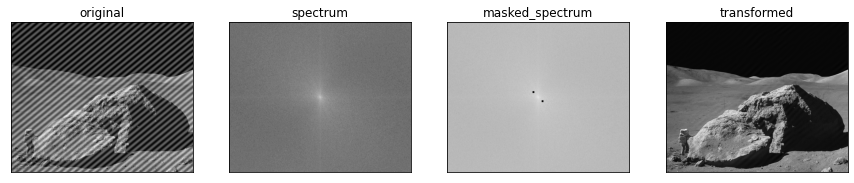

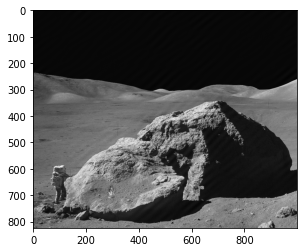

In [428]:
def P1():
    img_name = "astronaut-interference.tif"
    img = cv.imread(img_name, 1)
    channels = cv.split(img)
    channels_result = []
    
    for ci in range(len(channels)):
        B = channels[ci]
        dft = get_dft(B)
        dft2 = np.copy(dft) # for the transformed signal
        r, c = B.shape
        mask = np.ones((r,c,2))
        for i in range(380, 390):
            for j in range(470, 480):
                mask[i][j][0] = 0
                mask[i][j][1] = 0
        for i in range(430, 440):
            for j in range(520, 530):
                mask[i][j][0] = 0
                mask[i][j][1] = 0
        dft2 = dft2*mask
        spec = get_spectrum(dft)
        spec2 = get_spectrum(dft2)
        img1 = get_idft(mask)
        img2 = get_idft(dft2)
        channels_result += [img2]
        # Display
        if(ci == 0):
            n_plots = 4
            titles = ['original', 'spectrum', 'masked_spectrum', 'transformed']
            images = [img, spec, spec2, img2]
            fig, axs = plt.subplots(1, n_plots, figsize=[15, 15])

            for i in range(len(titles)):
                axs[i].imshow(images[i], 'gray')
                axs[i].set_title(titles[i])
                axs[i].set_xticks([]), axs[i].set_yticks([])
            plt.show()
    result = cv.merge(channels_result)
    return normed(result)
    
_ = P1()
plt.imshow(_)

## Problem 2 --- 'car-moire-pattern.tif

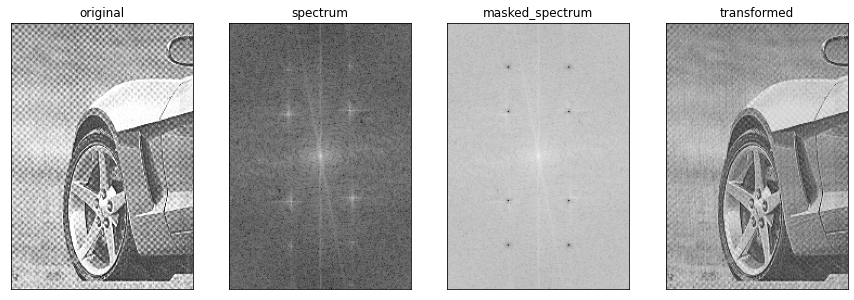

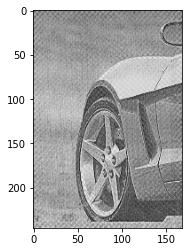

In [431]:
def P2():
    img_name = "car-moire-pattern.tif"
    img = cv.imread(img_name, 1)
    channels = cv.split(img)
    channels_result = []
    
    for ci in range(len(channels)):
        B = channels[ci]
        dft = get_dft(B)
        dft2 = np.copy(dft) # for the transformed signal
        r, c = B.shape
        us = [i*r/6. for i in [1,2,4,5]]
        vs = [i*c/3. for i in [1,2]]
        d0 = 20
        n = 2
        mask = np.ones((r,c,2))
        for ui in us:
            for vi in vs:
                mask *= get_BBRF(r, c, ui, vi, d0, n)
        dft2 = dft2*mask
        spec = get_spectrum(dft)
        spec2 = get_spectrum(dft2)
        img1 = get_idft(mask)
        img2 = get_idft(dft2)
        channels_result += [img2]
        # Display
        if(ci == 0):
            n_plots = 4
            titles = ['original', 'spectrum', 'masked_spectrum', 'transformed']
            images = [img, spec, spec2, img2]
            fig, axs = plt.subplots(1, n_plots, figsize=[15, 15])

            for i in range(len(titles)):
                axs[i].imshow(images[i], 'gray')
                axs[i].set_title(titles[i])
                axs[i].set_xticks([]), axs[i].set_yticks([])
            plt.show()
    result = cv.merge(channels_result)
    return normed(result)
    
_ = P2()
plt.imshow(_)

## Space for High Precision Denoising

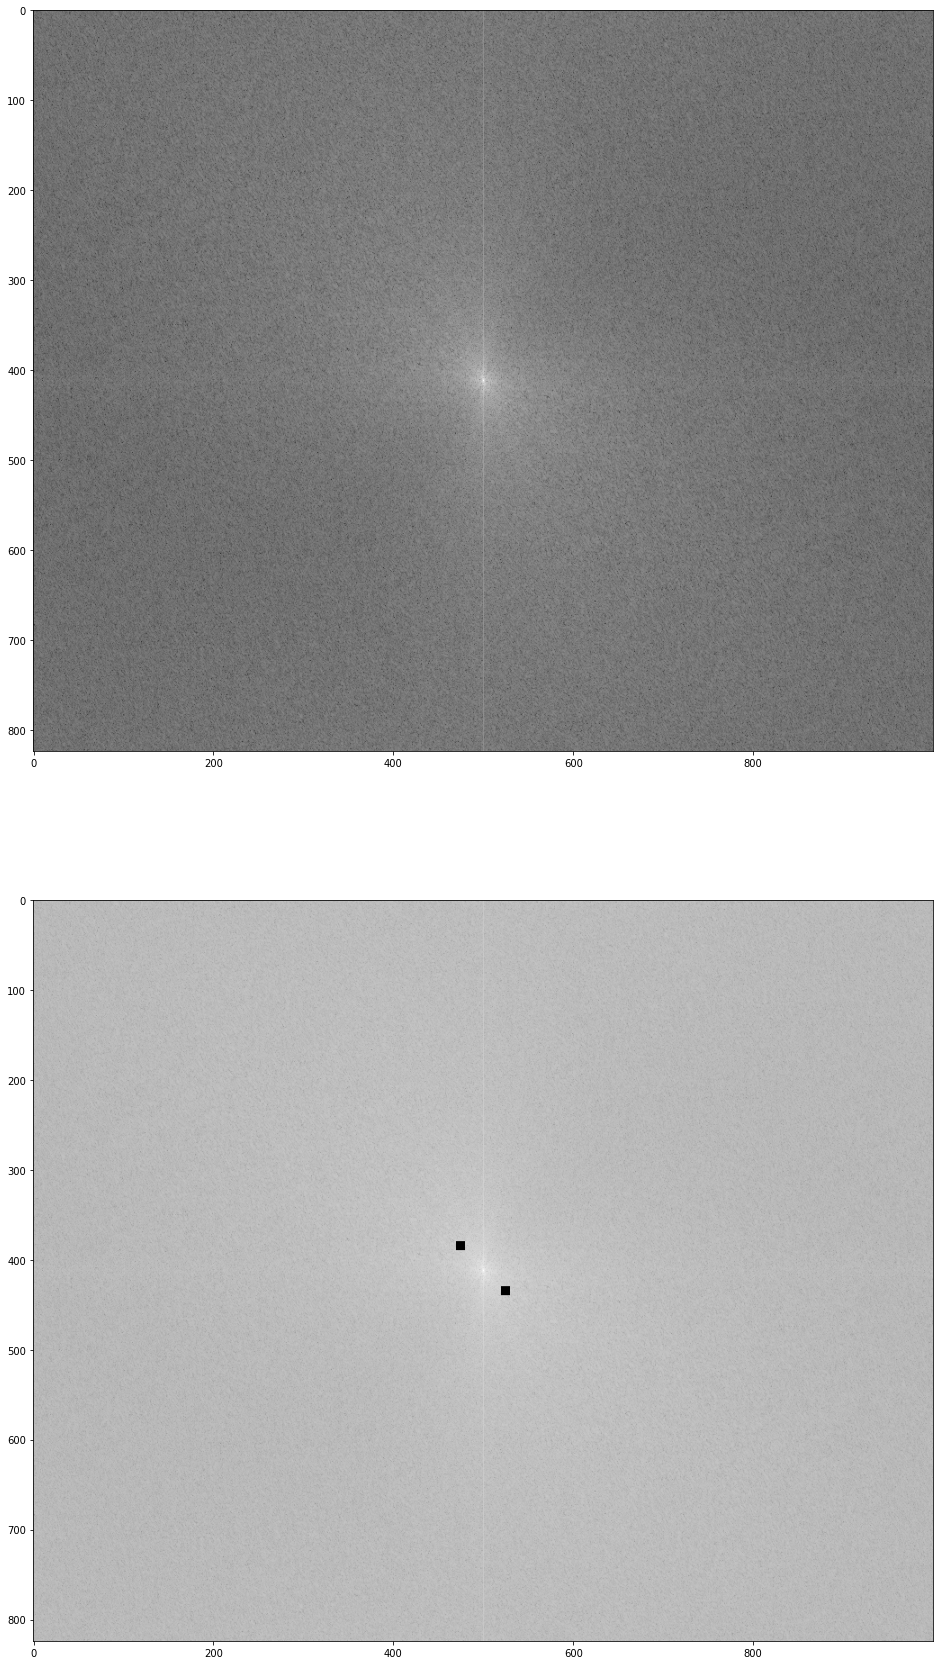

In [432]:
img_name = "astronaut-interference.tif"
img = cv.imread(img_name, 0)
dft = get_dft(img)
dft2 = np.copy(dft) # for the transformed signal
r, c = B.shape
mask = np.ones((r,c,2))
for i in range(380, 390):
    for j in range(470, 480):
        mask[i][j][0] = 0
        mask[i][j][1] = 0
for i in range(430, 440):
    for j in range(520, 530):
        mask[i][j][0] = 0
        mask[i][j][1] = 0
dft2 = dft2*mask
spec = get_spectrum(dft)
spec2 = get_spectrum(dft2)

fig, axs = plt.subplots(2, 1, figsize=[30, 30])
axs[0].imshow(spec, cmap = 'gray')
axs[1].imshow(spec2, cmap = 'gray')